# Real-time Steps

-- This needs to be verified if for analog we need different information

## Extras

In [1]:
ts_duration   = 10*1e-3; # in second
main_clk_freq = 50*1e6 # in Hz
tr_wrap       = int(ts_duration*main_clk_freq)
print(tr_wrap)

# 0: input for Xylo, 1: Xylo output
PDM_CLK_DIR  = 1
# 0: Xylo samples PDM_DATA at risinge edge, 1: Xylo samples PDM_DATA at falling edge
PDM_CLK_EDGE = 0

def get_tr_wrap(ts_in_ms, main_clk_freq_in_mhz, debug=0):
    ts_duration   = ts_in_ms*1e-3; # in second
    main_clk_freq = main_clk_freq_in_mhz*1e6 # in Hz
    tr_wrap       = int(ts_duration*main_clk_freq)
    print(f"set tr_wrap to 0x{format(tr_wrap,'_X')}") if debug>=1 else None
    return tr_wrap

500000


## Example with Rockpool

Open Dev Kit

* Call open_device() on a discovered device with Samna.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import rockpool
print(f'Rockpool version {rockpool.__version__}')
import samna
print(f'Samna version {samna.__version__}')
from rockpool.devices.xylo.syns65302 import config_from_specification, mapper, XyloMonitor, XyloSamna

from rockpool.devices.xylo import find_xylo_hdks

from rockpool.transform.quantize_methods import channel_quantize
from rockpool.nn.modules import LIF, Linear
from rockpool.nn.combinators import Sequential

import numpy as np

# find_xylo_hdks() directly calls the Samna device finder and opens all available devices.
# When Samna opens a device, it will perform actions on the board. Such as, powering on the chip, resetting it,
# applying a default configuration, and configuring the FPGA for default operation.

hdks, modules, versions = find_xylo_hdks()
print(hdks, modules, versions)

for version, xylo in zip(versions, hdks):
    if version == "syns65302":
        xylo_node = xylo

Rockpool version 2.8.6.dev
Samna version 0.39.0.0+dirty
from samna.xyloA3.configuration import InputInterfaceConfig
The connected Xylo HDK contains a Xylo A3. Importing `rockpool.devices.xylo.syns65302`
[<samna.xyloAudio3Boards.XyloAudio3TestBoard object at 0x74e6101818b0>] [<module 'rockpool.devices.xylo.syns65302' from '/home/vleite/Software/rockpool/rockpool/devices/xylo/syns65302/__init__.py'>] ['syns65302']


## Build a model and map it to hardware

In [3]:
# simple model to test

net = Sequential(
    Linear((16, 63)),
    LIF((63, 63)),

    Linear((63, 16)),
    LIF(16),
)

print(net)

# net[0].weight *= 0.05
spec = mapper(net.as_graph())
Q_spec = spec
Q_spec.update(channel_quantize(**Q_spec))
config, is_valid, msg = config_from_specification(**Q_spec)

if not is_valid:
    print(msg)

ModSequential  with shape (16, 16) {
    Linear '0_Linear' with shape (16, 63)
    LIF '1_LIF' with shape (63, 63)
    Linear '2_Linear' with shape (63, 16)
    LIF '3_LIF' with shape (16, 16)
}


## Set up Samna graphs and configuration

* Create a buffer sink for events from the chip model source node. Readout events will be captured here.
* Set Xylo configuration as desired for PDM and network config
* Set Xylo TR_WRAP register for desired time step length with default 25 MHz clock
* Set Xylo to real-time mode
* Enable PCB switches for PDM microphones
* Set FPGA module to real-time mode
   * io.write_config(0x12, 0) and io.write_config(0x31, 2)

In [4]:
# create xylo monitor
dt = 0.01
print(xylo_node)


config.operation_mode                                        = samna.xyloAudio3.OperationMode.RealTime
# inside XyloMonitor the buffers are created and FPGA modules are set
xylo_monitor = XyloMonitor(device=xylo_node, 
    config=config, 
    dt = dt,
    output_mode='Spike',
    digital_microphone = False)

# print(xylo_monitor)
xylo_monitor._write_buffer.write([samna.xyloAudio3.event.ReadRegisterValue(0x0004)])
print(xylo_monitor._read_buffer.get_n_events(1, 2000))
# print(xylo_monitor.config)


[xyloAudio3::event::RegisterValue(address=4, data=500000)]


In [5]:
import samna
print(f"samna version: {samna.__version__}")
import time

# set device configuration
ioc = xylo_node.get_io_control_module()
io = xylo_node.get_io_module()
model = xylo_node.get_model()

ctrl1 = 0x0001
ctrl2 = 0x0002
ctrl3 = 0x0003
tr_wrap = 0x0004
hm_tr_wrap = 0x0005
clk_ctrl = 0x0006
clk_div = 0x0007
pwr_ctrl1 = 0x0008
pwr_ctrl2 = 0x0009
pwr_ctrl3 = 0x000A
pwr_ctrl4 = 0x000B
pad_ctrl = 0x000C
ie1 = 0x000E
ie2 = 0x000F
out_ctrl = 0x0011
monsel = 0x0166
mon_grp_sel = 0x0167
dbg_ctrl1 = 0x0168
dbg_stat1 = 0x0171
dfe_ctrl = 0x001B
ivgen = 0x0015
ivgen2 = 0x0016
ivgen3 = 0x0017
ivgen4 = 0x0018
ivgen5 = 0x0019
ivgen6 = 0x001A
adctest = 0x016E

# create access to xylo input/output
source = samna.graph.source_to(model.get_sink_node())
sink   = samna.graph.sink_from(model.get_source_node())

# source.write([samna.xyloAudio3.event.WriteRegisterValue(address=dfe_ctrl, data=0x510)])

# source.write([samna.xyloAudio3.event.WriteRegisterValue(address=0x0015, data=0x7331_85F8)])
# source.write([samna.xyloAudio3.event.WriteRegisterValue(address=0x0016, data=0x1323_1107)])
# source.write([samna.xyloAudio3.event.WriteRegisterValue(address=0x0017, data=0x1112_1003)])
# source.write([samna.xyloAudio3.event.WriteRegisterValue(address=0x0018, data=0x0000_1210)])
# source.write([samna.xyloAudio3.event.WriteRegisterValue(address=0x0019, data=0x0000_0C07)])
# source.write([samna.xyloAudio3.event.WriteRegisterValue(address=0x001A, data=0x0000_0037)])


def read_register(addr):
    source.write([samna.xyloAudio3.event.ReadRegisterValue(address = addr)])
    events = sink.get_n_events(1, 3000)
    assert(len(events) == 1)
    return events[0].data

# print("\n# ======= read important registers =======\n")

# print(f"adctest       : 0x{format(read_register(adctest),'_X')}")
# print(f"ivgen       : 0x{format(read_register(ivgen),'_X')} vs 7331_85F8")
# print(f"ivgen2       : 0x{format(read_register(ivgen2),'_X')} vs 1323_1107")
# print(f"ivgen3       : 0x{format(read_register(ivgen3),'_X')} vs 1112_1003")
# print(f"ivgen4       : 0x{format(read_register(ivgen4),'_X')} vs 0000_1210")
# print(f"ivgen5       : 0x{format(read_register(ivgen5),'_X')} vs 0000_0C07")
# print(f"ivgen6       : 0x{format(read_register(ivgen6),'_X')} vs 0000_0031")
# # ctrl[1-3]
# print(f"ctrl1       : 0x{format(read_register(ctrl1),'_X')} vs 0x143_011C")
# print(f"ctrl2       : 0x{format(read_register(ctrl2),'_X')} vs 0x9_0902")
# print(f"ctrl3       : 0x{format(read_register(ctrl3),'_X')} vs 0x901")
# print()
# # *_wrap
# print(f"tr_wrap     : 0x{format(read_register(tr_wrap),'_X')} vs 0x2FA_F080")
# print(f"hm_tr_wrap  : 0x{format(read_register(hm_tr_wrap),'_X')} vs 0x0")
# print()
# # clk_*
# print(f"clk_ctrl    : 0x{format(read_register(clk_ctrl),'_X')} vs 0x11")
# print(f"clk_div     : 0x{format(read_register(clk_div),'_X')} vs 0x18_0000")
# print()
# # pwr_ctrl[1-4]
# print(f"pwr_ctrl1   : 0x{format(read_register(pwr_ctrl1),'_X')} vs 0x33_00FF")
# print(f"pwr_ctrl2   : 0x{format(read_register(pwr_ctrl2),'_X')} vs 0x3_0001")
# print(f"pwr_ctrl3   : 0x{format(read_register(pwr_ctrl3),'_X')} vs 0xFFFF_FFFF")
# print(f"pwr_ctrl4   : 0x{format(read_register(pwr_ctrl4),'_X')} vs 0xFFFF_0001")
# print()
# # misc
# print(f"pad_ctrl    : 0x{format(read_register(pad_ctrl),'_X')} vs 0x0")
# print(f"ie1         : 0x{format(read_register(ie1),'_X')} vs 0x0")
# print(f"ie2         : 0x{format(read_register(ie2),'_X')} vs 0x1")
# print(f"out_ctrl    : 0x{format(read_register(out_ctrl),'_X')} vs 0x70")
# print()
# # debug regs
# print(f"monsel      : 0x{format(read_register(monsel),'_X')} vs 0x0")
# print(f"mon_grp_sel : 0x{format(read_register(mon_grp_sel),'_X')} vs 0x1F1F_0773")
# print(f"dbg_ctrl1   : 0x{format(read_register(dbg_ctrl1),'_X')} vs 0x0")
# print(f"dbg_stat1   : 0x{format(read_register(dbg_stat1),'_X')} vs 0x0")
# print(f"dfe_ctrl   : 0x{format(read_register(dfe_ctrl),'_X')} vs 0x510")
print()



samna version: 0.39.0.0+dirty



## Start processing and collect events

* Send TriggerProcessing event from Samna with the desired time step
* Collect readout events in the BufferSink attached to the model source node

In [6]:
import numpy as np
N = 2 # in seconds

out, _, rec = xylo_monitor.evolve(record=False, record_power=False, read_timeout=N)
print(out)
print(np.sum(out))


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0], [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0], [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0],

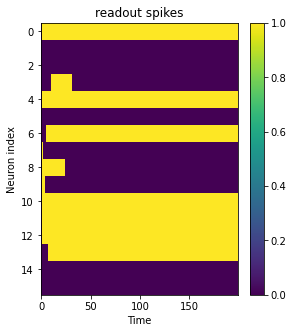

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(np.array(out).T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()